In [1]:

import sys
sys.path.insert(1, "..")
import pprint
import gpytorch
import torch
import numpy as np
import metrics
import copy
import configparser
from experiment_functions import Experiment
from GaussianProcess import ExactGPModel
from globalParams import options, hyperparameter_limits
import gpytorch
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import clean_kernel_expression
from helpFunctions import get_kernels_in_kernel_expression
from helpFunctions import amount_of_base_kernels
from itertools import product
import json
from kernelSearch import *
from matplotlib import pyplot as plt
from metrics import *
from multiprocessing import Pool
import numpy as np
import os
import pdb
import pickle
import random
import tikzplotlib
import time
import torch
from tqdm import tqdm
from scipy.stats import multivariate_normal
import matplotlib as mpl

# To run STAN in a Jupyter notebook
import nest_asyncio
nest_asyncio.apply()



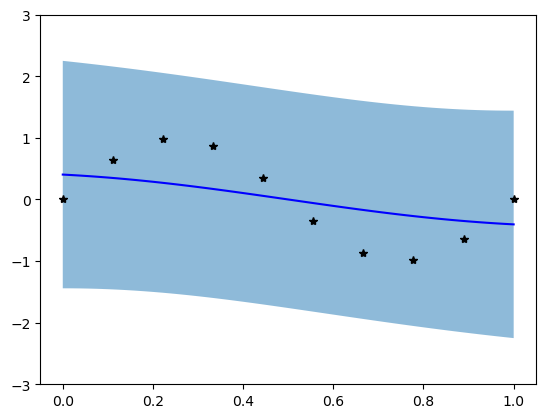

In [2]:
import torch
import gpytorch
import matplotlib.pyplot as plt

# Define the training data
train_x = torch.linspace(0, 1, 10)
train_y = torch.sin(train_x * (2 * 3.1416))

# Define the Gaussian Process model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)



# Make predictions with the model
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

# Plot the results
with torch.no_grad():
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()
plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
plt.plot(test_x.numpy(), mean.numpy(), 'b')
plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.ylim([-3, 3])
plt.show()

In [3]:
def log_prior(model, theta_mu=None, sigma=None):
    # params -
    # TODO de-spaghettize this once the priors are coded properly
    prior_dict = {'SE': {'raw_lengthscale' : {"mean": -0.21221139138922668 , "std":1.8895426067756804}},
                  'MAT52': {'raw_lengthscale' :{"mean": 0.7993038925994188, "std":2.145122566357853 } },
                  'MAT32': {'raw_lengthscale' :{"mean": 1.5711054238673443, "std":2.4453761235991216 } },
                  'RQ': {'raw_lengthscale' :{"mean": -0.049841950913676276, "std":1.9426354614713097 },
                          'raw_alpha' :{"mean": 1.882148553921053, "std":3.096431944989054 } },
                  'PER':{'raw_lengthscale':{"mean": 0.7778461197268618, "std":2.288946656544974 },
                          'raw_period_length':{"mean": 0.6485334993738499, "std":0.9930632050553377 } },
                  'LIN':{'raw_variance' :{"mean": -0.8017903983055685, "std":0.9966569921354465 } },
                  'c':{'raw_outputscale':{"mean": -1.6253091096349706, "std":2.2570021716661923 } },
                  'noise': {'raw_noise':{"mean": -3.51640656386717, "std":3.5831320474767407 }}}
    #prior_dict = {"SE": {"raw_lengthscale": {"mean": 0.891, "std": 2.195}},
    #              "MAT": {"raw_lengthscale": {"mean": 1.631, "std": 2.554}},
    #              "PER": {"raw_lengthscale": {"mean": 0.338, "std": 2.636},
    #                      "raw_period_length": {"mean": 0.284, "std": 0.902}},
    #              "LIN": {"raw_variance": {"mean": -1.463, "std": 1.633}},
    #              "c": {"raw_outputscale": {"mean": -2.163, "std": 2.448}},
    #              "noise": {"raw_noise": {"mean": -1.792, "std": 3.266}}}

    variances_list = list()
    debug_param_name_list = list()
    theta_mu = list()
    params = list()
    covar_string = gsr(model.covar_module)
    covar_string = covar_string.replace("(", "")
    covar_string = covar_string.replace(")", "")
    covar_string = covar_string.replace(" ", "")
    covar_string = covar_string.replace("PER", "PER+PER")
    covar_string_list = [s.split("*") for s in covar_string.split("+")]
    covar_string_list.insert(0, ["LIKELIHOOD"])
    covar_string_list = list(chain.from_iterable(covar_string_list))
    both_PER_params = False
    for (param_name, param), cov_str in zip(model.named_parameters(), covar_string_list):
        params.append(param.item())
        debug_param_name_list.append(param_name)
        # First param is (always?) noise and is always with the likelihood
        if "likelihood" in param_name:
            theta_mu.append(prior_dict["noise"]["raw_noise"]["mean"])
            variances_list.append(prior_dict["noise"]["raw_noise"]["std"])
            continue
        else:
            if (cov_str == "PER" or cov_str == "RQ") and not both_PER_params:
                theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                both_PER_params = True
            elif (cov_str == "PER" or cov_str == "RQ") and both_PER_params:
                theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                both_PER_params = False
            else:
                try:
                    theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                    variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                except Exception as E:
                    import pdb
                    pdb.set_trace()
                    prev_cov = cov_str
    theta_mu = torch.tensor(theta_mu)
    theta_mu = theta_mu.unsqueeze(0).t()
    sigma = torch.diag(torch.Tensor(variances_list))
    sigma = sigma@sigma
    prior = torch.distributions.MultivariateNormal(theta_mu.t(), sigma)

    # for convention reasons I'm diving by the number of datapoints
    return prior.log_prob(torch.Tensor(params)).item() / len(*model.train_inputs)

def optimize_hyperparameters(model, likelihood, train_iterations, X, Y, with_BFGS=False, MAP=False, prior=None, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    ## Setup
    # Log the parameters found during training
    log_param_path = kwargs.get("log_param_path", False)
    log_likelihood = kwargs.get("log_likelihood", False)
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    best_loss = 1e400
    optimal_parameters = dict()
    limits = hyperparameter_limits
    if log_param_path:
        param_log_list = list()
    if log_likelihood:
        likelihood_logs = list()
    # start runs
    for iteration in range(random_restarts):
    #for iteration in range(2):
        if log_likelihood:
            likelihood_log = list()
        if log_param_path:
            param_log_dict = {param_name[0] : list() for param_name in model.named_parameters()}
        # optimize and determine loss
        # Perform a training for AIC and Laplace
        model.train()
        likelihood.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(train_iterations):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(X)
            # Calc loss and backprop gradients
            loss = -mll(output, Y)
            if MAP:
                log_p = log_prior(model)
                loss -= log_p
            loss.backward()
            optimizer.step()
            if log_param_path:
                for param_name in model.named_parameters():
                    param_log_dict[param_name[0]].append(param_name[1].item())
            if log_likelihood:
                likelihood_log.append(loss.item())

        if with_BFGS:
            # Additional BFGS optimization to better ensure optimal parameters
            # LBFGS_optimizer = torch.optim.LBFGS(model.parameters(), max_iter=50, line_search_fn='strong_wolfe')
            LBFGS_optimizer = torch.optim.LBFGS(
                model.parameters(), max_iter=500, max_eval=10000, tolerance_grad=1e-1, tolerance_change=1e-1,
                line_search_fn='strong_wolfe')
            # define closure
            training_iterations=50
            def closure():
                LBFGS_optimizer.zero_grad()
                output = model(X)
                loss = -mll(output, Y)
                if MAP:
                    log_p = log_prior(model)
                    loss -= log_p
                loss.backward()
                if log_param_path:
                    for param_name in model.named_parameters():
                        param_log_dict[param_name[0]].append(param_name[1].item())
                if log_likelihood:
                    likelihood_log.append(loss.item())
                return loss
            LBFGS_optimizer.step(closure)

        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X)
        # Calc loss and backprop gradients
        loss = -mll(output, Y)
        if MAP:
            log_p = log_prior(model)
            loss -= log_p

#        model.train_model(with_BFGS=with_BFGS)
        current_loss = loss
        # check if the current run is better than previous runs
        if current_loss < best_loss:
            # if it is the best, save all used parameters
            best_loss = current_loss
            for param_name, param in model.named_parameters():
                optimal_parameters[param_name] = copy.deepcopy(param)

        # set new random inital values
        model.likelihood.noise_covar.noise = torch.rand(1) * (limits["Noise"][1] - limits["Noise"][0]) + limits["Noise"][0]
        #self.mean_module.constant = torch.rand(1) * (limits["Mean"][1] - limits["Mean"][0]) + limits["Mean"][0]
        for kernel in get_kernels_in_kernel_expression(model.covar_module):
            hypers = limits[kernel._get_name()]
            for hyperparameter in hypers:
                new_value = torch.rand(1) * (hypers[hyperparameter][1] - hypers[hyperparameter][0]) + hypers[hyperparameter][0]
                setattr(kernel, hyperparameter, new_value)

        # print output if enabled
        if options["training"]["print_optimizing_output"]:
            print(f"HYPERPARAMETER OPTIMIZATION: Random Restart {iteration}: loss: {current_loss}, optimal loss: {best_loss}")
        if log_likelihood:
            likelihood_logs.append(likelihood_log)
        if log_param_path:
            param_log_list.append(param_log_dict)

    # finally, set the hyperparameters those in the optimal run
    model.initialize(**optimal_parameters)
    output = model(X)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    loss = -mll(output, Y)
    if MAP:
        log_p = log_prior(model)
        loss -= log_p
    if not loss == best_loss:
        import pdb
        pdb.set_trace()
        print(loss)
        print(best_loss)
    logables = dict()
    if log_param_path:
        logables["training_log"] = param_log_dict
    if log_likelihood:
        logables["likelihood_log"] = likelihood_log
    if len(logables.keys()) > 0:
        return loss, logables
    return loss

In [4]:
#torch.autograd.grad(loss, [p for p in model.parameters()], retain_graph=True, create_graph=True, allow_unused=True)

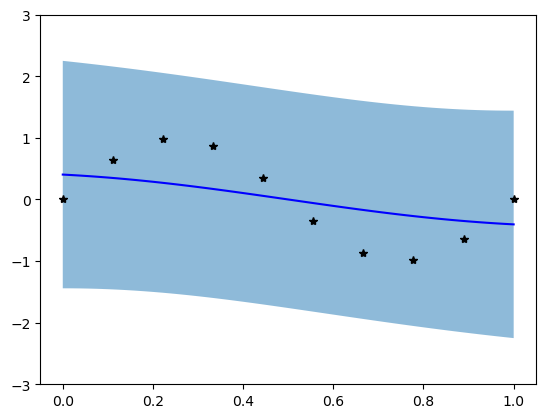

In [5]:


# Make predictions with the model
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

# Plot the results
with torch.no_grad():
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()
plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
plt.plot(test_x.numpy(), mean.numpy(), 'b')
plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.ylim([-3, 3])
plt.show()

In [6]:
def log_prior(model, theta_mu=None, sigma=None):
    # params -
    # TODO de-spaghettize this once the priors are coded properly
    prior_dict = {'SE': {'raw_lengthscale' : {"mean": -0.21221139138922668 , "std":1.8895426067756804}},
                  'MAT52': {'raw_lengthscale' :{"mean": 0.7993038925994188, "std":2.145122566357853 } },
                  'MAT32': {'raw_lengthscale' :{"mean": 1.5711054238673443, "std":2.4453761235991216 } },
                  'RQ': {'raw_lengthscale' :{"mean": -0.049841950913676276, "std":1.9426354614713097 },
                          'raw_alpha' :{"mean": 1.882148553921053, "std":3.096431944989054 } },
                  'PER':{'raw_lengthscale':{"mean": 0.7778461197268618, "std":2.288946656544974 },
                          'raw_period_length':{"mean": 0.6485334993738499, "std":0.9930632050553377 } },
                  'LIN':{'raw_variance' :{"mean": -0.8017903983055685, "std":0.9966569921354465 } },
                  'c':{'raw_outputscale':{"mean": -1.6253091096349706, "std":2.2570021716661923 } },
                  'noise': {'raw_noise':{"mean": -3.51640656386717, "std":3.5831320474767407 }}}
    #prior_dict = {"SE": {"raw_lengthscale": {"mean": 0.891, "std": 2.195}},
    #              "MAT": {"raw_lengthscale": {"mean": 1.631, "std": 2.554}},
    #              "PER": {"raw_lengthscale": {"mean": 0.338, "std": 2.636},
    #                      "raw_period_length": {"mean": 0.284, "std": 0.902}},
    #              "LIN": {"raw_variance": {"mean": -1.463, "std": 1.633}},
    #              "c": {"raw_outputscale": {"mean": -2.163, "std": 2.448}},
    #              "noise": {"raw_noise": {"mean": -1.792, "std": 3.266}}}

    variances_list = list()
    debug_param_name_list = list()
    theta_mu = list()
    params = list()
    covar_string = gsr(model.covar_module)
    covar_string = covar_string.replace("(", "")
    covar_string = covar_string.replace(")", "")
    covar_string = covar_string.replace(" ", "")
    covar_string = covar_string.replace("PER", "PER+PER")
    covar_string_list = [s.split("*") for s in covar_string.split("+")]
    covar_string_list.insert(0, ["LIKELIHOOD"])
    covar_string_list = list(chain.from_iterable(covar_string_list))
    both_PER_params = False
    for (param_name, param), cov_str in zip(model.named_parameters(), covar_string_list):
        params.append(param.item())
        debug_param_name_list.append(param_name)
        # First param is (always?) noise and is always with the likelihood
        if "likelihood" in param_name:
            theta_mu.append(prior_dict["noise"]["raw_noise"]["mean"])
            variances_list.append(prior_dict["noise"]["raw_noise"]["std"])
            continue
        else:
            if (cov_str == "PER" or cov_str == "RQ") and not both_PER_params:
                theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                both_PER_params = True
            elif (cov_str == "PER" or cov_str == "RQ") and both_PER_params:
                theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                both_PER_params = False
            else:
                try:
                    theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                    variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                except Exception as E:
                    import pdb
                    pdb.set_trace()
                    prev_cov = cov_str
    theta_mu = torch.tensor(theta_mu)
    theta_mu = theta_mu.unsqueeze(0).t()
    sigma = torch.diag(torch.Tensor(variances_list))
    sigma = sigma@sigma
    prior = torch.distributions.MultivariateNormal(theta_mu.t(), sigma)

    # for convention reasons I'm diving by the number of datapoints
    return prior.log_prob(torch.Tensor(params)).item() / len(*model.train_inputs)

def optimize_hyperparameters(model, likelihood, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    log_param_path = kwargs.get("log_param_path", False)
    log_likelihood = kwargs.get("log_likelihood", False)
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    train_iterations = kwargs.get("train_iterations", 50)
    X = kwargs.get("X", model.train_inputs)
    Y = kwargs.get("Y", model.train_targets)
    with_BFGS = kwargs.get("with_BFGS", False)
    MAP = kwargs.get("MAP", False)
    prior = kwargs.get("prior", False)



    if log_likelihood:
        likelihood_log = list()
    if log_param_path:
        param_log_dict = {param_name[0] : list() for param_name in model.named_parameters()}

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    for _ in range(train_iterations):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X)
        # Calc loss and backprop gradients
        loss = -mll(output, Y)
        if MAP:
            log_p = log_prior(model)
            loss -= log_p
        loss.backward()
        optimizer.step()
        if log_param_path:
            for param_name in model.named_parameters():
                param_log_dict[param_name[0]].append(param_name[1].item())
        if log_likelihood:
            likelihood_log.append(loss.item())




    optimizer = torch.optim.LBFGS(model.parameters(), max_iter=50)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        if MAP:
            log_p = log_prior(model)
            loss -= log_p
        loss.backward()
        print("I was called!")
        print(f"loss:{loss}")
        return loss
    print(optimizer.step(closure))

    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    if MAP:
        log_p = log_prior(model)
        loss -= log_p
    print(loss)
    return loss

In [7]:


# Train the model using Adam
#model.train()
#likelihood.train()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
#training_iterations = 50
#for i in range(training_iterations):
#    optimizer.zero_grad()
#    output = model(train_x)
#    loss = -mll(output, train_y)
#    loss.backward()
#    optimizer.step()

# Train the model using LBFGS
loss = optimize_hyperparameters(model, likelihood, MAP=True)


I was called!
loss:1.7525032758712769
I was called!
loss:1.719207763671875
I was called!
loss:1.0196341276168823
I was called!
loss:1.3510706424713135
I was called!
loss:0.8426333069801331
I was called!
loss:0.6914984583854675
I was called!
loss:0.6029602885246277
I was called!
loss:0.5028441548347473
I was called!
loss:0.45070573687553406
I was called!
loss:51.38835525512695
I was called!
loss:0.3050690293312073
I was called!
loss:0.3206430673599243
I was called!
loss:0.43582653999328613
I was called!
loss:1.0233922004699707
I was called!
loss:2.1120591163635254
I was called!
loss:1.181311845779419
I was called!
loss:1.281516432762146
I was called!
loss:1.4703266620635986
I was called!
loss:1.41166090965271
I was called!
loss:1.4184200763702393
I was called!
loss:1.438360571861267
I was called!
loss:1.437278389930725
I was called!
loss:1.4327857494354248
I was called!
loss:1.431511640548706
I was called!
loss:1.430993914604187
I was called!
loss:1.4313294887542725
I was called!
loss:1

In [8]:
torch.autograd.grad(loss, [p for p in model.parameters()], retain_graph=True, create_graph=True, allow_unused=True)

(tensor([1.2793e-07], grad_fn=<SoftplusBackwardBackward0>),
 tensor(6.8861e-06, grad_fn=<SoftplusBackwardBackward0>),
 tensor([[-8.1785e-05]], grad_fn=<SoftplusBackwardBackward0>))

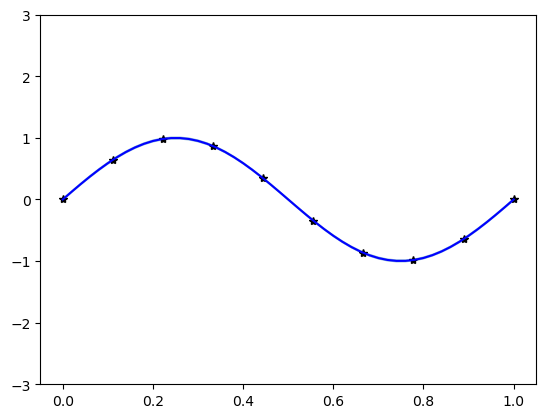

In [9]:


# Make predictions with the model
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

# Plot the results
with torch.no_grad():
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()
plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
plt.plot(test_x.numpy(), mean.numpy(), 'b')
plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.ylim([-3, 3])
plt.show()